In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats


In [3]:
kfolds = 10
lambs = ['100', '1000', '10000', '100000', '1e+06']
cutoff = 1/(3*10**9)

In [163]:
def pull_performance(recomb_file):
    genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_train, co_in_hotspot_pat_train = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_test, co_in_hotspot_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    
    lengths = np.load('%s.lengths.npy' % recomb_file)

    for i, lamb in enumerate(lambs):
        for k in range(kfolds):
            try:

                co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_in_hotspot_mat_train[i, k] = np.sum(np.log(co_ps_mat_train))/len(co_ps_mat_train)
                co_in_hotspot_mat_test[i, k] = np.sum(np.log(co_ps_mat_test))/len(co_ps_mat_test)
                
                co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_in_hotspot_pat_train[i, k] = np.sum(np.log(co_ps_pat_train))/len(co_ps_pat_train)
                co_in_hotspot_pat_test[i, k] = np.sum(np.log(co_ps_pat_test))/len(co_ps_pat_test)
            except Exception as e:
                print(e)
    return co_in_hotspot_mat_train, co_in_hotspot_pat_train, co_in_hotspot_mat_test, co_in_hotspot_pat_test

#wgs_genome_in_hotspot_mat, wgs_genome_in_hotspot_pat, wgs_genome_in_hotspot, \
#wgs_co_in_hotspot_mat_train, wgs_co_in_hotspot_pat_train, \
#wgs_co_in_hotspot_mat_test, wgs_co_in_hotspot_pat_test = pull_data('../recombination_rate/ihart.ms2')

#chip_genome_in_hotspot_mat, chip_genome_in_hotspot_pat, chip_genome_in_hotspot, \
#chip_co_in_hotspot_mat_train, chip_co_in_hotspot_pat_train, \
#chip_co_in_hotspot_mat_test, chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip')

#wgs_chip_genome_in_hotspot_mat, wgs_chip_genome_in_hotspot_pat, wgs_chip_genome_in_hotspot, \
#wgs_chip_co_in_hotspot_mat_train, wgs_chip_co_in_hotspot_pat_train, \
#wgs_chip_co_in_hotspot_mat_test, wgs_chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip')

wgs_linked_co_in_hotspot_mat_train, wgs_linked_co_in_hotspot_pat_train, \
wgs_linked_co_in_hotspot_mat_test, wgs_linked_co_in_hotspot_pat_test = pull_performance('../recombination_rate/ihart.ms2_linked_min')

wgs_linked_phen_co_in_hotspot_mat_train, wgs_linked_phen_co_in_hotspot_pat_train, \
wgs_linked_phen_co_in_hotspot_mat_test, wgs_linked_phen_co_in_hotspot_pat_test = pull_performance('../recombination_rate/ihart.ms2_linked_min_phen')

wgs_co_in_hotspot_mat_train, wgs_co_in_hotspot_pat_train, \
wgs_co_in_hotspot_mat_test, wgs_co_in_hotspot_pat_test = pull_performance('../recombination_rate/wgs_linked_min')

chip_linked_co_in_hotspot_mat_train, chip_linked_co_in_hotspot_pat_train, \
chip_linked_co_in_hotspot_mat_test, chip_linked_co_in_hotspot_pat_test = pull_performance('../recombination_rate/spark_linked_min')

#wgs_chip_linked_genome_in_hotspot_mat, wgs_chip_linked_genome_in_hotspot_pat, wgs_chip_linked_genome_in_hotspot, \
#wgs_chip_linked_co_in_hotspot_mat_train, wgs_chip_linked_co_in_hotspot_pat_train, \
#wgs_chip_linked_co_in_hotspot_mat_test, wgs_chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip_linked')


[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min.crossover_ps_mat_train.100.9.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linked_min_phen.crossover_ps_mat_train.100.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/ihart.ms2_linke

[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_train.1e+06.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.crossover_ps_mat_tr

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


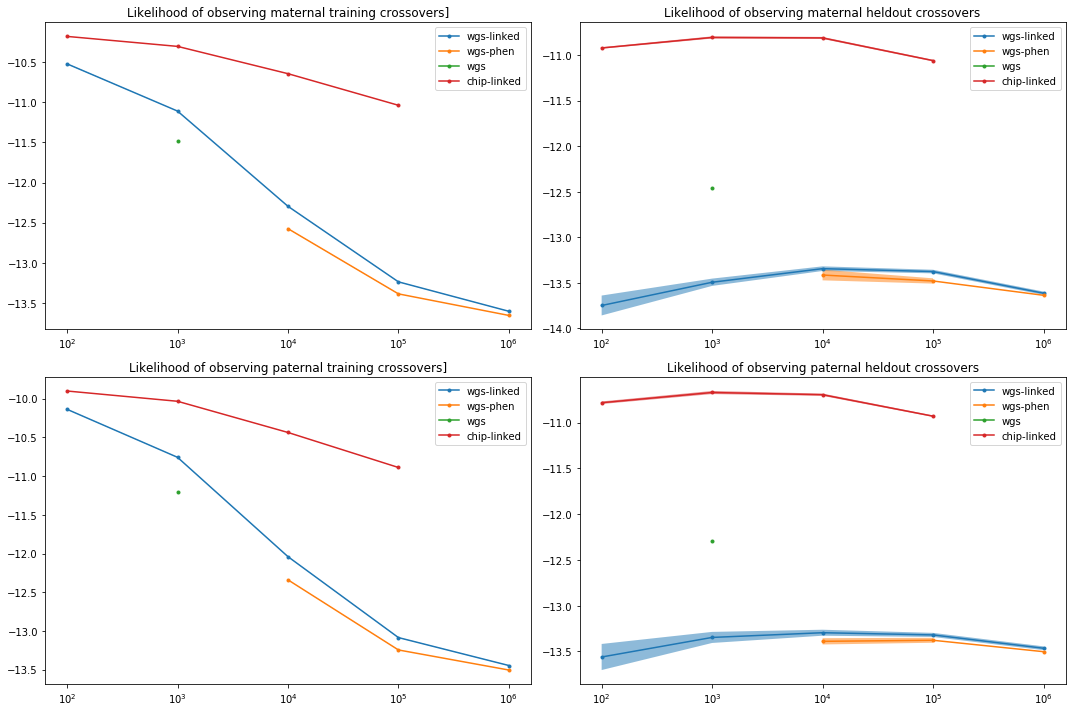

In [165]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(np.nanmean(data, axis=1), label=label, marker='.')
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(np.arange(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
#plot_with_confidence(wgs_co_in_hotspot_mat_train, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_mat_train, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_mat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_train, 'wgs-linked')
plot_with_confidence(wgs_linked_phen_co_in_hotspot_mat_train, 'wgs-phen')
plot_with_confidence(wgs_co_in_hotspot_mat_train, 'wgs')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_mat_train, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_mat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_train, 'both-linked')
plt.title('Likelihood of observing maternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 2, 3)
#plot_with_confidence(wgs_co_in_hotspot_pat_train, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_pat_train, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_pat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_train, 'wgs-linked')
plot_with_confidence(wgs_linked_phen_co_in_hotspot_pat_train, 'wgs-phen')
plot_with_confidence(wgs_co_in_hotspot_pat_train, 'wgs')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_pat_train, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_pat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_train, 'both-linked')
plt.title('Likelihood of observing paternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 2, 2)
#plot_with_confidence(wgs_co_in_hotspot_mat_test, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_mat_test, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_mat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_test, 'wgs-linked')
plot_with_confidence(wgs_linked_phen_co_in_hotspot_mat_test, 'wgs-phen')
plot_with_confidence(wgs_co_in_hotspot_mat_test, 'wgs')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_mat_test, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_mat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_test, 'both-linked')
plt.title('Likelihood of observing maternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 2, 4)
#plot_with_confidence(wgs_co_in_hotspot_pat_test, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_pat_test, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_pat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_test, 'wgs-linked')
plot_with_confidence(wgs_linked_phen_co_in_hotspot_pat_test, 'wgs-phen')
plot_with_confidence(wgs_co_in_hotspot_pat_test, 'wgs')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_pat_test, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_pat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_test, 'both-linked')
plt.title('Likelihood of observing paternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.tight_layout()
plt.show()

In [166]:
def pull_data(recomb_file):
    genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_train, co_in_hotspot_pat_train = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_test, co_in_hotspot_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    
    lengths = np.load('%s.lengths.npy' % recomb_file)

    for i, lamb in enumerate(lambs):
        for k in range(kfolds):
            try:
                ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
                is_mat_hotspot = (ps_mat/lengths > cutoff)

                co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_mat_train = np.clip(co_ps_mat_train, co_lengths_mat_train*10**-12, None)
                co_ps_mat_test = np.clip(co_ps_mat_test, co_lengths_mat_test*10**-12, None)
                genome_in_hotspot_mat[i, k] = is_mat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_mat_train[i, k] = np.sum(np.log(co_ps_mat_train))/len(co_ps_mat_train)
                co_in_hotspot_mat_test[i, k] = np.sum(np.log(co_ps_mat_test))/len(co_ps_mat_test)

                ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
                is_pat_hotspot = (ps_pat/lengths > cutoff)

                co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_pat_train = np.clip(co_ps_pat_train, co_lengths_pat_train*10**-12, None)
                co_ps_pat_test = np.clip(co_ps_pat_test, co_lengths_pat_test*10**-12, None)
                genome_in_hotspot_pat[i, k] = is_pat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_pat_train[i, k] = np.sum(np.log(co_ps_pat_train))/len(co_ps_pat_train)
                co_in_hotspot_pat_test[i, k] = np.sum(np.log(co_ps_pat_test))/len(co_ps_pat_test)
                genome_in_hotspot[i, k] = (is_mat_hotspot & is_pat_hotspot).dot(lengths)/np.sum(lengths)
            except Exception as e:
                print(e)
    return genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot, co_in_hotspot_mat_train, co_in_hotspot_pat_train, co_in_hotspot_mat_test, co_in_hotspot_pat_test

#wgs_genome_in_hotspot_mat, wgs_genome_in_hotspot_pat, wgs_genome_in_hotspot, \
#wgs_co_in_hotspot_mat_train, wgs_co_in_hotspot_pat_train, \
#wgs_co_in_hotspot_mat_test, wgs_co_in_hotspot_pat_test = pull_data('../recombination_rate/ihart.ms2')

#chip_genome_in_hotspot_mat, chip_genome_in_hotspot_pat, chip_genome_in_hotspot, \
#chip_co_in_hotspot_mat_train, chip_co_in_hotspot_pat_train, \
#chip_co_in_hotspot_mat_test, chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip')

#wgs_chip_genome_in_hotspot_mat, wgs_chip_genome_in_hotspot_pat, wgs_chip_genome_in_hotspot, \
#wgs_chip_co_in_hotspot_mat_train, wgs_chip_co_in_hotspot_pat_train, \
#wgs_chip_co_in_hotspot_mat_test, wgs_chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip')

wgs_linked_genome_in_hotspot_mat, wgs_linked_genome_in_hotspot_pat, wgs_linked_genome_in_hotspot, \
wgs_linked_co_in_hotspot_mat_train, wgs_linked_co_in_hotspot_pat_train, \
wgs_linked_co_in_hotspot_mat_test, wgs_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_linked_min')

chip_linked_genome_in_hotspot_mat, chip_linked_genome_in_hotspot_pat, chip_linked_genome_in_hotspot, \
chip_linked_co_in_hotspot_mat_train, chip_linked_co_in_hotspot_pat_train, \
chip_linked_co_in_hotspot_mat_test, chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/spark_linked_min')

#wgs_chip_linked_genome_in_hotspot_mat, wgs_chip_linked_genome_in_hotspot_pat, wgs_chip_linked_genome_in_hotspot, \
#wgs_chip_linked_co_in_hotspot_mat_train, wgs_chip_linked_co_in_hotspot_pat_train, \
#wgs_chip_linked_co_in_hotspot_mat_test, wgs_chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip_linked')


[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked_min.ps_mat.100.9.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/spark_linked_min.ps_mat.1e+06.9.npy'


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


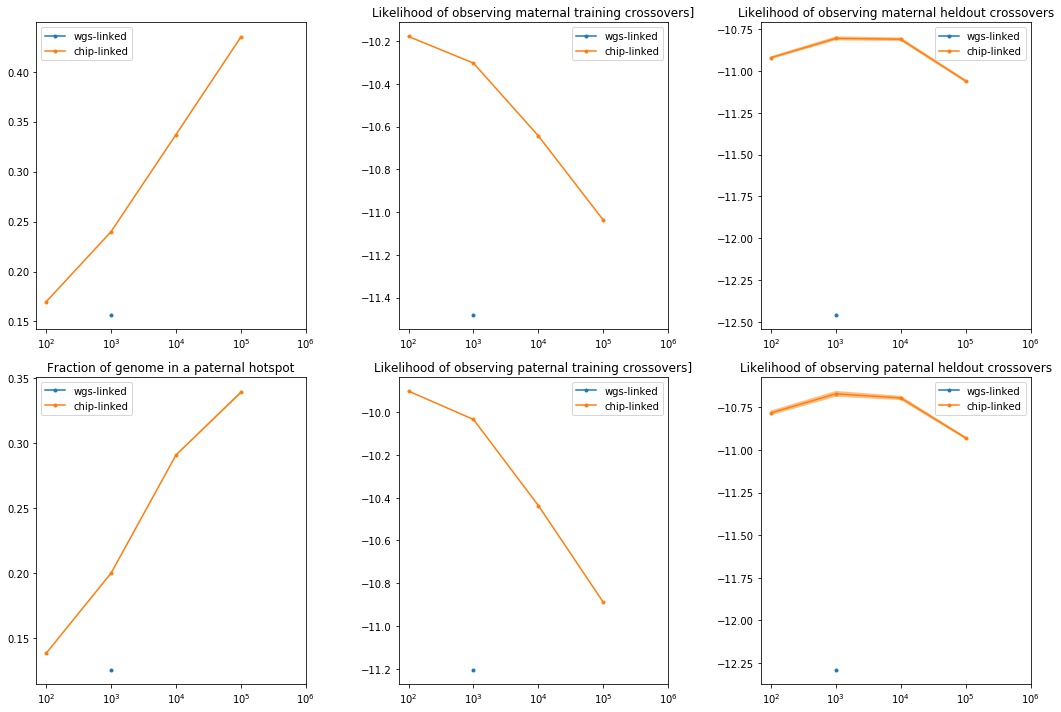

In [167]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(np.nanmean(data, axis=1), label=label, marker='.')
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(np.arange(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
#plot_with_confidence(wgs_genome_in_hotspot_mat, 'wgs')
#plot_with_confidence(chip_genome_in_hotspot_mat, 'chip')
#plot_with_confidence(wgs_chip_genome_in_hotspot_mat, 'both')
plot_with_confidence(wgs_linked_genome_in_hotspot_mat, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_genome_in_hotspot_mat, 'wgs-linked_min')
plot_with_confidence(chip_linked_genome_in_hotspot_mat, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_genome_in_hotspot_mat, 'both-linked')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 4)
#plot_with_confidence(wgs_genome_in_hotspot_pat, 'wgs')
#plot_with_confidence(chip_genome_in_hotspot_pat, 'chip')
#plot_with_confidence(wgs_chip_genome_in_hotspot_pat, 'both')
plot_with_confidence(wgs_linked_genome_in_hotspot_pat, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_genome_in_hotspot_pat, 'wgs-linked_min')
plot_with_confidence(chip_linked_genome_in_hotspot_pat, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_genome_in_hotspot_pat, 'both-linked')
plt.title('Fraction of genome in a paternal hotspot')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 2)
#plot_with_confidence(wgs_co_in_hotspot_mat_train, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_mat_train, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_mat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_train, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_mat_train, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_mat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_train, 'both-linked')
plt.title('Likelihood of observing maternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 5)
#plot_with_confidence(wgs_co_in_hotspot_pat_train, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_pat_train, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_pat_train, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_train, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_pat_train, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_pat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_train, 'both-linked')
plt.title('Likelihood of observing paternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 3)
#plot_with_confidence(wgs_co_in_hotspot_mat_test, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_mat_test, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_mat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_mat_test, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_mat_test, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_mat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_test, 'both-linked')
plt.title('Likelihood of observing maternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 6)
#plot_with_confidence(wgs_co_in_hotspot_pat_test, 'wgs')
#plot_with_confidence(chip_co_in_hotspot_pat_test, 'chip')
#plot_with_confidence(wgs_chip_co_in_hotspot_pat_test, 'both')
plot_with_confidence(wgs_linked_co_in_hotspot_pat_test, 'wgs-linked')
#plot_with_confidence(wgs_linked_min_co_in_hotspot_pat_test, 'wgs-linked_min')
plot_with_confidence(chip_linked_co_in_hotspot_pat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_test, 'both-linked')
plt.title('Likelihood of observing paternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.tight_layout()
plt.show()

In [168]:
lamb_wgs_mat = lambs[np.argmax(np.nanmean(wgs_linked_co_in_hotspot_mat_test, axis=1))]
lamb_wgs_pat = lambs[np.argmax(np.nanmean(wgs_linked_co_in_hotspot_pat_test, axis=1))]
lamb_chip_mat = lambs[np.argmax(np.nanmean(chip_linked_co_in_hotspot_mat_test, axis=1))]
lamb_chip_pat = lambs[np.argmax(np.nanmean(chip_linked_co_in_hotspot_pat_test, axis=1))]
#lamb_wgschip_mat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_mat_test, axis=1))]
#lamb_wgschip_pat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_pat_test, axis=1))]

print(lamb_wgs_mat, lamb_wgs_pat)
print(lamb_chip_mat, lamb_chip_pat)
#print(lamb_chip_mat, lamb_chip_pat)
#print(lamb_wgschip_mat, lamb_wgschip_pat)

100 100
1e+06 1e+06


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


# Look at best performers

205609 (205608,) (205608,) (205608,)
[('1', 1), ('1', 67223), ('1', 80346), ('1', 86331), ('1', 89946)]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10


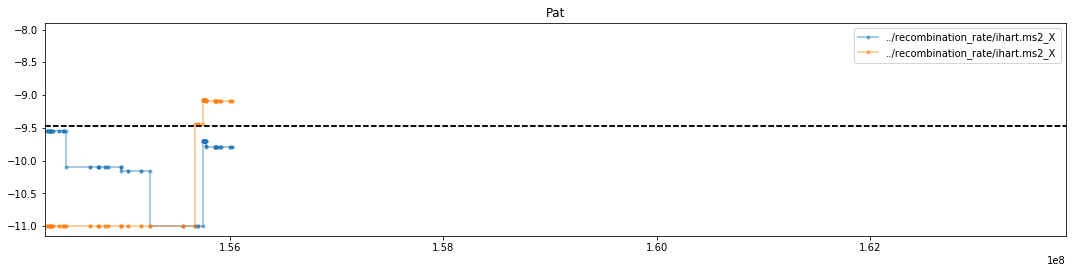

In [13]:
chrom = 'X'
plt.figure(figsize=(15, 7))

for recomb_file, lamb in [('../recombination_rate/ihart.ms2_X', '100000')
                        #('../recombination_rate/wgs_linked_min', '1000'),
                          #('../recombination_rate/spark_linked_min', '1000'),
                           # ('../recombination_rate/spark_linked_min', '10000')
                         ]:
    all_positions = []
    with open('%s.positions.txt' % recomb_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            all_positions.append((pieces[0], int(pieces[1])))
    lengths = np.load('%s.lengths.npy' % recomb_file)

    try:
        ps_mat = np.load('%s.ps_mat.%s.npy' % (recomb_file, lamb))
        ps_pat = np.load('%s.ps_pat.%s.npy' % (recomb_file, lamb))
    except FileNotFoundError:
        ps_mat = np.load('%s.ps_mat.%s.0.npy' % (recomb_file, lamb))
        ps_pat = np.load('%s.ps_pat.%s.0.npy' % (recomb_file, lamb))
    print(len(all_positions), lengths.shape, ps_mat.shape, ps_pat.shape)
    print(all_positions[:5])

    plt.subplot(2, 1, 1)
    plt.title('Mat')
    indices = [c==chrom for c, p in all_positions[:-1]]
    p = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
                     np.repeat((np.clip(np.log10(ps_mat)-np.log10(lengths), -12, None))[indices], 2)[:-1], marker='.', alpha=0.5, label=recomb_file)
    plt.axhline(np.log10(cutoff), color='black', linestyle='--')
    #plt.xlim([10000000, 11000000])
    plt.legend()
        
    #plt.subplot(2, 1, 2)
    plt.title('Pat')
    indices = [c==chrom for c, p in all_positions[:-1]]
    q = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
                     np.repeat((np.clip(np.log10(ps_pat)-np.log10(lengths), -12, None))[indices], 2)[:-1], marker='.', alpha=0.5, label=recomb_file)
    plt.axhline(np.log10(cutoff), color='black', linestyle='--')
    #plt.xlim([0, 10000000])
    plt.xlim([154270560, None])
    plt.legend()
    #plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

plt.tight_layout()
plt.show()


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in subtract


64457


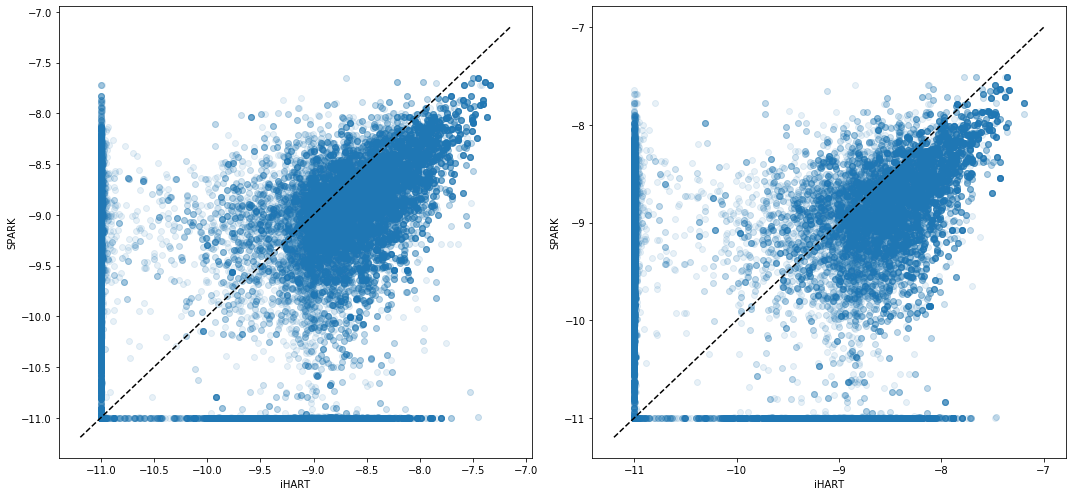

In [173]:
chrom = '1'
plt.figure(figsize=(15, 7))


xs = []
mats, pats = [], []
for recomb_file, lamb in [('../recombination_rate/wgs_linked_min', '1000'),
                          ('../recombination_rate/spark_linked_min', '1000')]:
    try:
        all_positions = []
        with open('%s.positions.txt' % recomb_file, 'r') as f:
            for line in f:
                pieces = line.strip().split('\t')
                all_positions.append((pieces[0], int(pieces[1])))
        lengths = np.load('%s.lengths.npy' % recomb_file)

        try:
            ps_mat = np.load('%s.ps_mat.%s.npy' % (recomb_file, lamb))
            ps_pat = np.load('%s.ps_pat.%s.npy' % (recomb_file, lamb))
        except FileNotFoundError:
            ps_mat = np.load('%s.ps_mat.%s.0.npy' % (recomb_file, lamb))
            ps_pat = np.load('%s.ps_pat.%s.0.npy' % (recomb_file, lamb))

        xs.append(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:])

        indices = [c==chrom for c, p in all_positions[:-1]]
        mats.append(np.repeat((np.clip(np.log10(ps_mat)-np.log10(lengths), -12, None))[indices], 2)[:-1])
        
        indices = [c==chrom for c, p in all_positions[:-1]]
        pats.append(np.repeat((np.clip(np.log10(ps_pat)-np.log10(lengths), -12, None))[indices], 2)[:-1])
    except:
        pass
    
positions = sorted(set(xs[0].tolist() + xs[1].tolist()))
pos_to_index = dict([x, i] for i, x in enumerate(positions))
print(len(positions))

# interval, first/second, mat/pat
data = np.zeros((len(positions), 2, 2))
data[:] = np.nan
for i, x in enumerate(xs[0][:-1]):
    start_index = pos_to_index[x]
    end_index = pos_to_index[xs[0][i+1]]
    data[start_index:end_index, 0, 0] = mats[0][i]
    data[start_index:end_index, 0, 1] = pats[0][i]
    
for i, x in enumerate(xs[1][:-1]):
    start_index = pos_to_index[x]
    end_index = pos_to_index[xs[1][i+1]]
    data[start_index:end_index, 1, 0] = mats[1][i]
    data[start_index:end_index, 1, 1] = pats[1][i]
    
plt.subplot(1, 2, 1) 
plt.scatter(data[:, 0, 0], data[:, 1, 0], alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('iHART')
plt.ylabel('SPARK')

plt.subplot(1, 2, 2) 
plt.scatter(data[:, 0, 1], data[:, 1, 1], alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.xlabel('iHART')
plt.ylabel('SPARK')

plt.tight_layout()
plt.show()


1000


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.


Maternal
genome in hotspot 0.15600891895186839
train crossovers in hotspot 0.9516195343737908
test crossovers in hotspot 0.75392382833937


No handles with labels found to put in legend.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.


Paternal
genome in hotspot 0.12535633981408356
train crossovers in hotspot 0.9648112120582514
test crossovers in hotspot 0.7663159105284343
Both


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:95: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:96: RuntimeWarning: divide by zero encountered in true_divide
No handles with labels found to put in legend.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in subtract


genome in both hotspot 0.059027577203003195
genome in only mat hotspot 0.09698134174886518
genome in only pat hotspot 0.06632876261108038
1000


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


Maternal
genome in hotspot 0.2391306463666193
train crossovers in hotspot 0.8564109143431818
test crossovers in hotspot 0.7420942720763724


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

Paternal
genome in hotspot 0.2001250987173398
train crossovers in hotspot 0.8831437568279673
test crossovers in hotspot 0.754108870497727
Both
genome in both hotspot 0.1061347237557963
genome in only mat hotspot 0.132995922610823
genome in only pat hotspot 0.0939903749615435


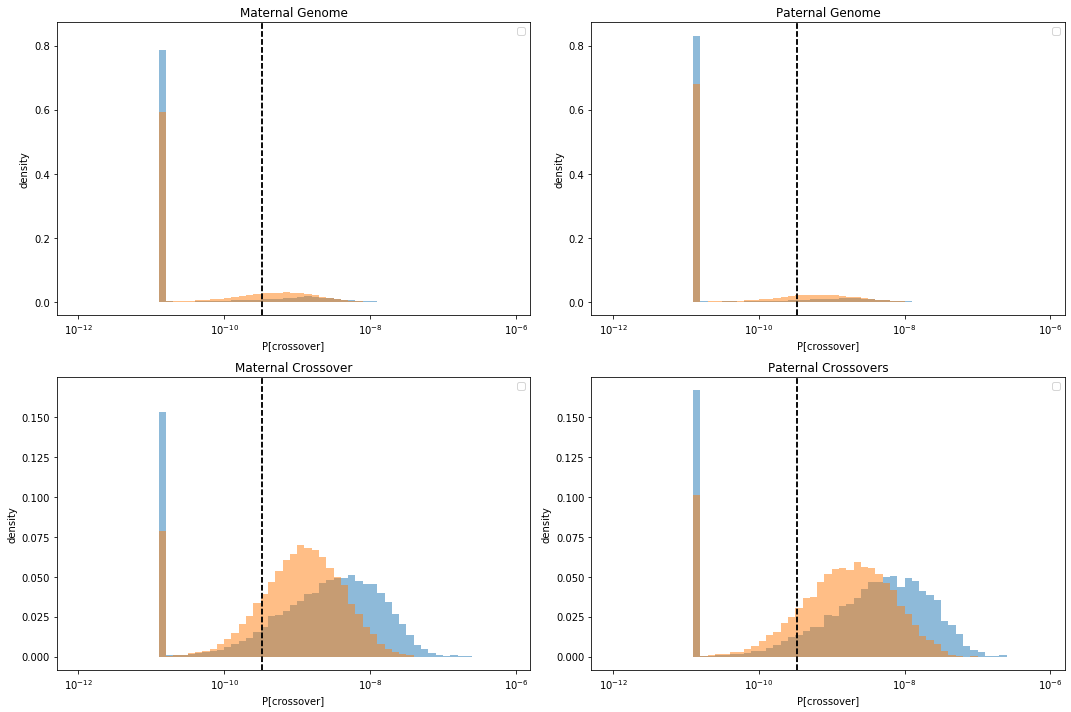

In [174]:
plt.figure(figsize=(15, 10))
bins = np.arange(-12, -6, 0.1)
k = 0

for recomb_file, lamb in [('../recombination_rate/wgs_linked_min', '1000'), 
                          ('../recombination_rate/spark_linked_min', '1000')]:
    print(lamb)

    lengths = np.load('%s.lengths.npy' % recomb_file)

    ax1 = plt.subplot(2, 2, 1)
    #co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
    #co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%.0f.%d.npy' % (recomb_file, lamb, k))

    #X_mat_train = sparse.load_npz('%s.X_mat_train.%s.%d.npz' % (recomb_file, lamb, k))
    #X_mat_test = sparse.load_npz('%s.X_mat_test.%s.%d.npz' % (recomb_file, lamb, k))

    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    genome = np.zeros((len(bins)+1,))
    for index, l in zip(np.digitize(np.log10(ps_mat)-np.log10(lengths), bins), lengths):
        genome[index] += l
    plt.fill_between(np.repeat(bins, 2)[1:-1], np.repeat(genome[:-1]/np.sum(genome), 2)[:-2], 0, alpha=0.5)
    is_hotspot_mat = (ps_mat/lengths > cutoff)

    co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
    co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
    co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
    co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

    print('Maternal')
    print('genome in hotspot', (ps_mat/lengths > cutoff).dot(lengths)/np.sum(lengths))
    print('train crossovers in hotspot', np.sum(co_ps_mat_train/co_lengths_mat_train > cutoff)/len(co_ps_mat_train))
    print('test crossovers in hotspot', np.sum(co_ps_mat_test/co_lengths_mat_test > cutoff)/len(co_ps_mat_test))

    plt.title('Maternal Genome')
    plt.xlabel('P[crossover]')
    plt.ylabel('density')
    plt.xticks(np.arange(-12, -5, 2), ['$10^{%d}$' % x for x in np.arange(-12, -5, 2)])
    plt.legend()
    plt.axvline(np.log10(cutoff), color='black', linestyle='--')
    
    ax2 = plt.subplot(2, 2, 3)
    #plt.hist(np.clip(np.log10(co_ps_mat_train) - np.log10(co_lengths_mat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
    cross = np.zeros((len(bins)+1,))
    for index, _ in zip(np.digitize(np.log10(co_ps_mat_test)-np.log10(co_lengths_mat_test), bins), lengths):
        cross[index] += 1
    plt.fill_between(np.repeat(bins, 2)[1:-1], np.repeat(cross[:-1]/np.sum(cross), 2)[:-2], 0, alpha=0.5)

    plt.title('Maternal Crossover')
    plt.xlabel('P[crossover]')
    plt.ylabel('density')
    plt.xticks(np.arange(-12, -5, 2), ['$10^{%d}$' % x for x in np.arange(-12, -5, 2)])
    plt.legend()
    plt.axvline(np.log10(cutoff), color='black', linestyle='--')

    plt.subplot(2, 2, 2, sharey=ax1)
    #co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
    #co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%.0f.%d.npy' % (recomb_file, lamb, k))

    #X_pat_train = sparse.load_npz('%s.X_pat_train.%s.%d.npz' % (recomb_file, lamb, k))
    #X_pat_test = sparse.load_npz('%s.X_pat_test.%s.%d.npz' % (recomb_file, lamb, k))

    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    genome = np.zeros((len(bins)+1,))
    for index, l in zip(np.digitize(np.log10(ps_pat)-np.log10(lengths), bins), lengths):
        genome[index] += l
    plt.fill_between(np.repeat(bins, 2)[1:-1], np.repeat(genome[:-1]/np.sum(genome), 2)[:-2], 0, alpha=0.5)

    co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
    co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
    co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
    co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))

    print('Paternal')
    print('genome in hotspot', (ps_pat/lengths > cutoff).dot(lengths)/np.sum(lengths))
    print('train crossovers in hotspot', np.sum(co_ps_pat_train/co_lengths_pat_train > cutoff)/len(co_ps_pat_train))
    print('test crossovers in hotspot', np.sum(co_ps_pat_test/co_lengths_pat_test > cutoff)/len(co_ps_pat_test))

    plt.title('Paternal Genome')
    plt.xlabel('P[crossover]')
    plt.xticks(np.arange(-12, -5, 2), ['$10^{%d}$' % x for x in np.arange(-12, -5, 2)])
    plt.ylabel('density')
    plt.legend()  
    plt.axvline(np.log10(cutoff), color='black', linestyle='--')
    
    plt.subplot(2, 2, 4, sharey=ax2)
    #plt.hist(np.clip(np.log10(co_ps_pat_train) - np.log10(co_lengths_pat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
    cross = np.zeros((len(bins)+1,))
    for index, _ in zip(np.digitize(np.log10(co_ps_pat_test)-np.log10(co_lengths_pat_test), bins), lengths):
        cross[index] += 1
    plt.fill_between(np.repeat(bins, 2)[1:-1], np.repeat(cross[:-1]/np.sum(cross), 2)[:-2], 0, alpha=0.5)

    print('Both')
    print('genome in both hotspot', ((ps_mat/lengths > cutoff) & (ps_pat/lengths > cutoff)).dot(lengths)/np.sum(lengths))
    print('genome in only mat hotspot', ((ps_mat/lengths > cutoff) & ~(ps_pat/lengths > cutoff)).dot(lengths)/np.sum(lengths))
    print('genome in only pat hotspot', (~(ps_mat/lengths > cutoff) & (ps_pat/lengths > cutoff)).dot(lengths)/np.sum(lengths))

    plt.title('Paternal Crossovers')
    plt.xlabel('P[crossover]')
    plt.xticks(np.arange(-12, -5, 2), ['$10^{%d}$' % x for x in np.arange(-12, -5, 2)])
    plt.ylabel('density')
    plt.legend()  
    plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered 

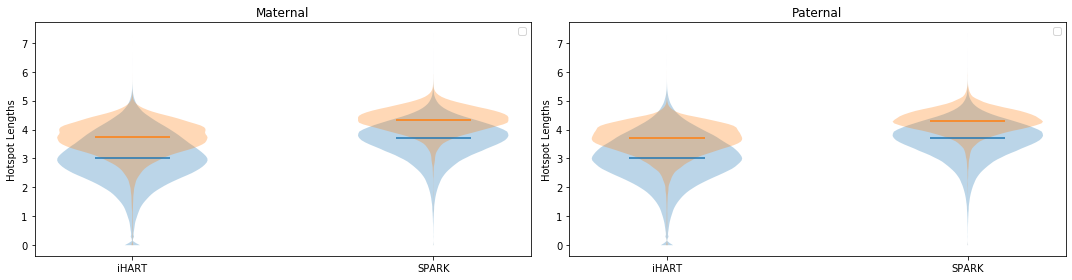

In [175]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
mat_res = []
mat_data = []
for recomb_file, lamb, label in zip(['../recombination_rate/wgs_linked_min', '../recombination_rate/spark_linked_min', '../recombination_rate/ihart.ms2_linked_min'],
                                    ['1000', '1000'],
                                    ['wgs', 'spark']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_mat = (ps_mat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1, np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
    if is_hotspot_mat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_mat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_mat)))
    assert len(hotspot_starts) == len(hotspot_ends)
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    mat_res.append(np.clip(np.log10(lengths), 0, 8))
    mat_data.append(np.clip(np.log10(hotspot_length), 0, 8))
plt.violinplot(mat_res, showmedians=True, showextrema=False)
plt.violinplot(mat_data, showmedians=True, showextrema=False)
plt.xticks(np.arange(len(mat_data))+1, ['iHART', 'SPARK'])
plt.title('Maternal')
plt.ylabel('Hotspot Lengths')
plt.legend()

plt.subplot(1, 2, 2)
pat_res = []
pat_data = []
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/spark_linked_min', '../recombination_rate/ihart.ms2_linked_min'],
                                    ['1000', '1000'],
                                    ['wgs', 'spark']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_pat = (ps_pat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1, np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
    if is_hotspot_pat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_pat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_pat)))
    assert len(hotspot_starts) == len(hotspot_ends)
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    pat_res.append(np.clip(np.log10(lengths), 0, 8))
    pat_data.append(np.clip(np.log10(hotspot_length), 0, 8))
plt.violinplot(pat_res, showmedians=True, showextrema=False)
plt.violinplot(pat_data, showmedians=True, showextrema=False)
plt.xticks(np.arange(len(pat_data))+1, ['iHART', 'SPARK'])
plt.title('Paternal')
plt.ylabel('Hotspot Lengths')
plt.legend()  

plt.tight_layout()
plt.show()

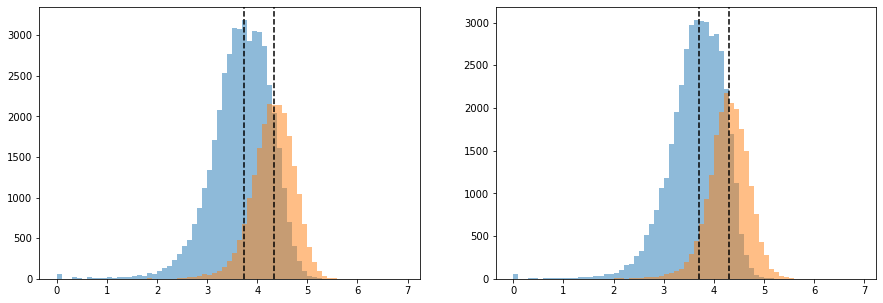

In [181]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(mat_data[0], alpha=0.5, bins=np.arange(0, 7, 0.1))
plt.axvline(np.median(mat_data[0]), color='black', linestyle='--')
plt.hist(mat_data[1], alpha=0.5, bins=np.arange(0, 7, 0.1))
plt.axvline(np.median(mat_data[1]), color='black', linestyle='--')
plt.subplot(1, 2, 2)
plt.hist(pat_data[0], alpha=0.5, bins=np.arange(0, 7, 0.1))
plt.axvline(np.median(pat_data[0]), color='black', linestyle='--')
plt.hist(pat_data[1], alpha=0.5, bins=np.arange(0, 7, 0.1))
plt.axvline(np.median(pat_data[1]), color='black', linestyle='--')
plt.show()

# Something else

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in subtract


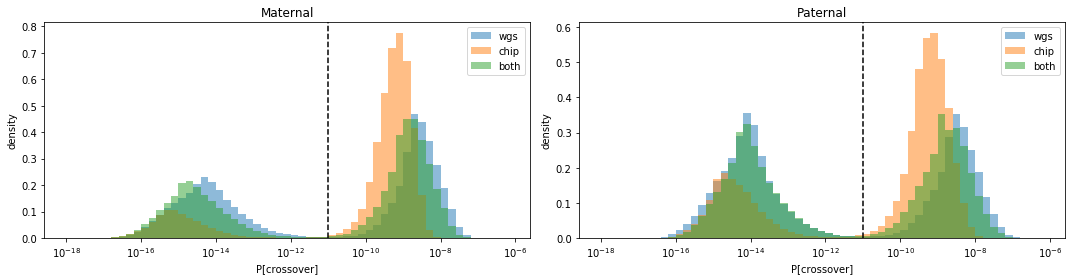

In [377]:
plt.figure(figsize=(15, 4))
bins = np.arange(-18, -6, 0.2)
plt.subplot(1, 2, 1)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label=label)

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-18, -4, 2), ['$10^{%d}$' % x for x in np.arange(-18, -4, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label=label)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-18, -4, 2), ['$10^{%d}$' % x for x in np.arange(-18, -4, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()